# Reproducing EEG2Code with deep Learning

## System Architecture
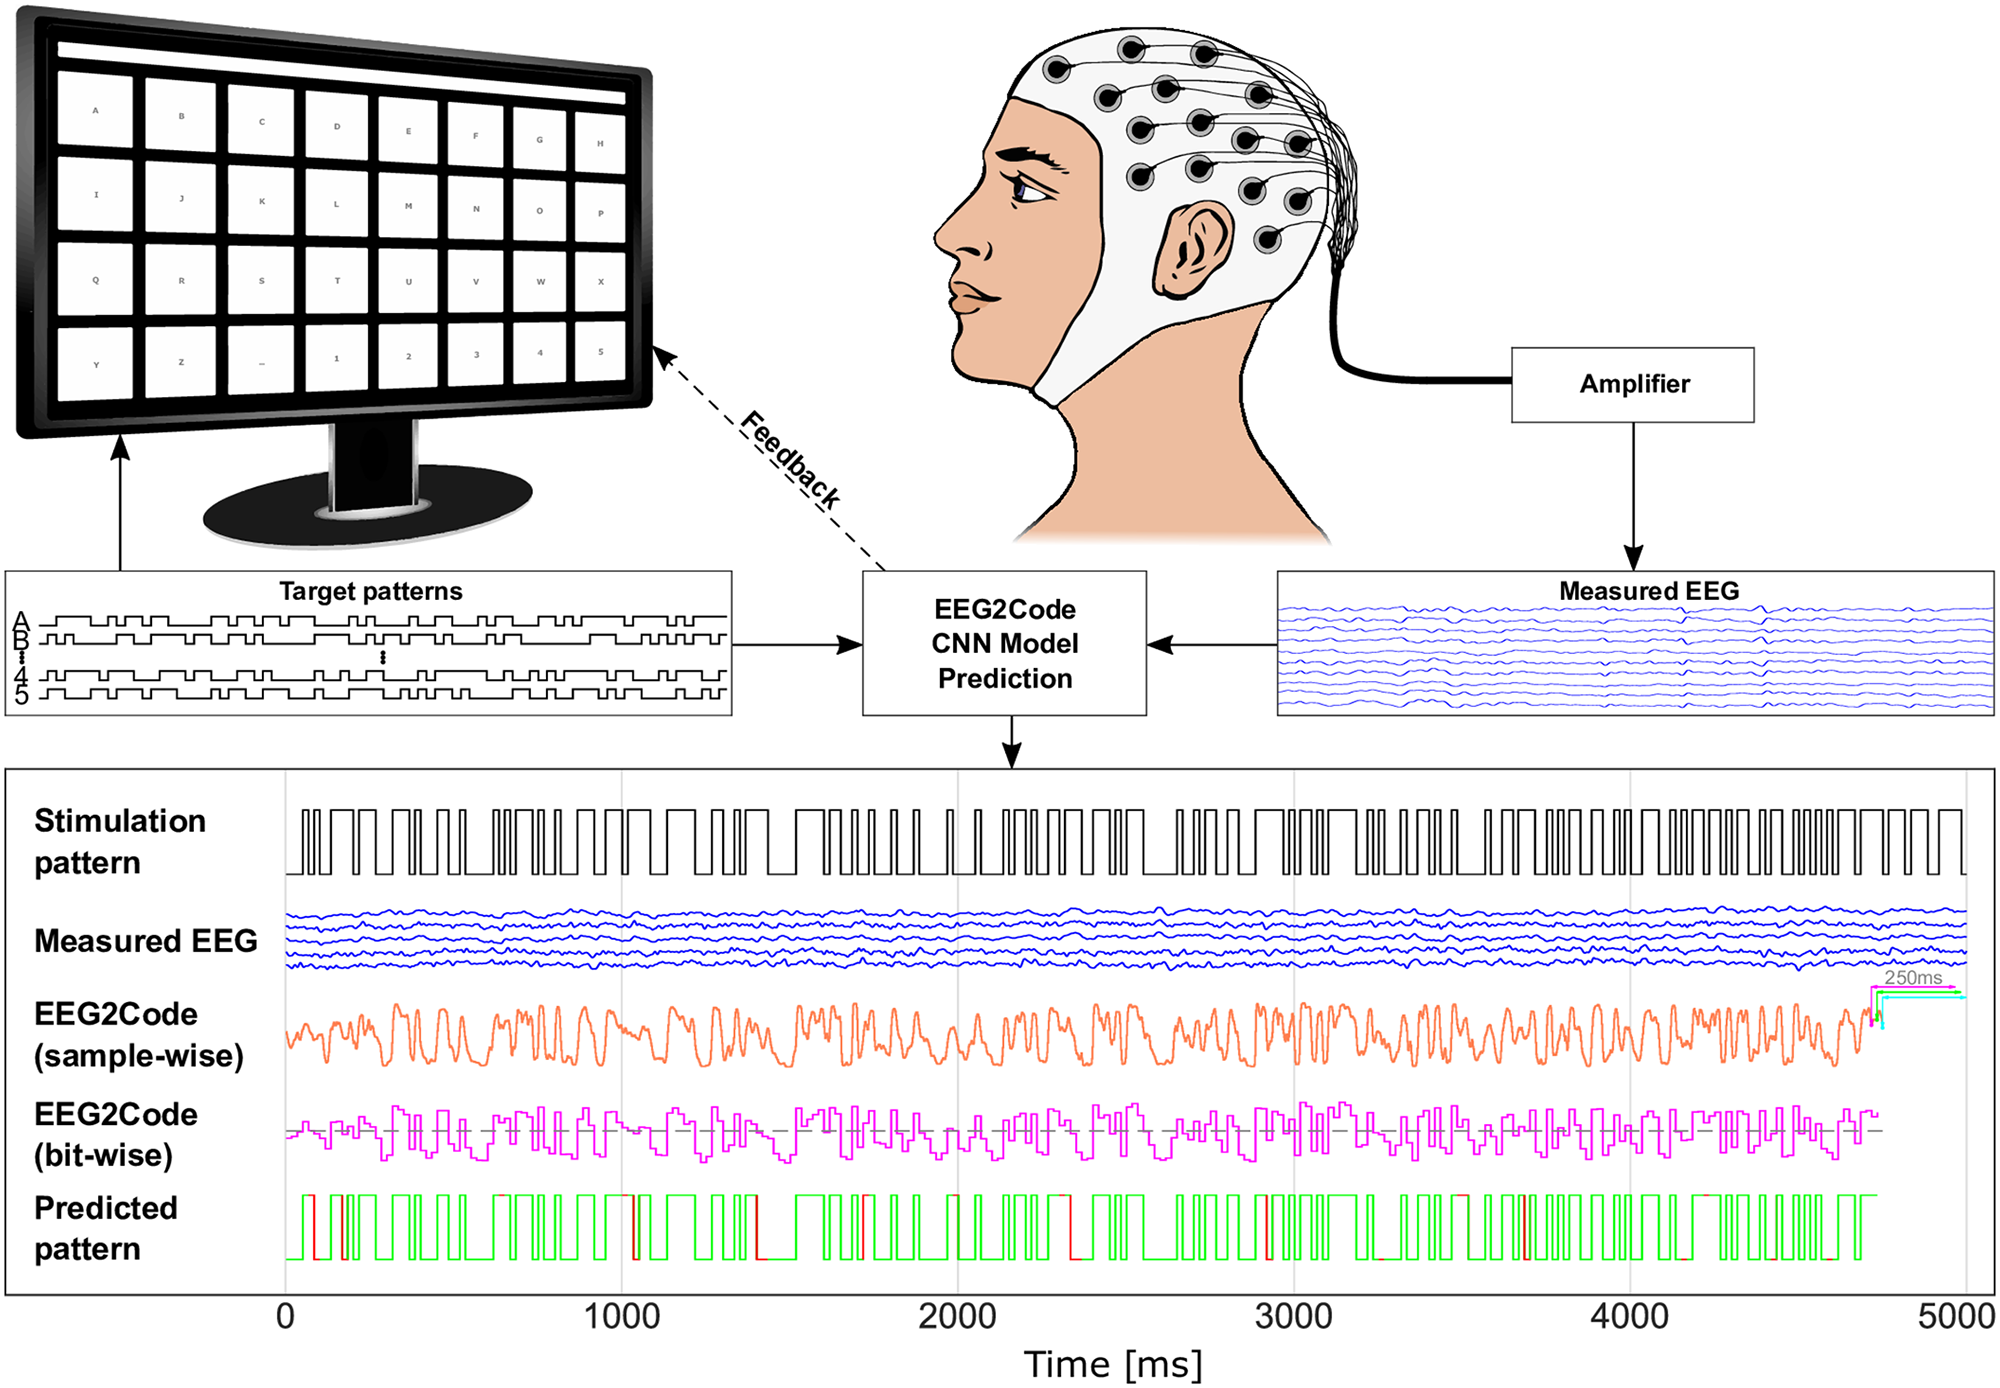


## EEG2Code Deep Learning Model
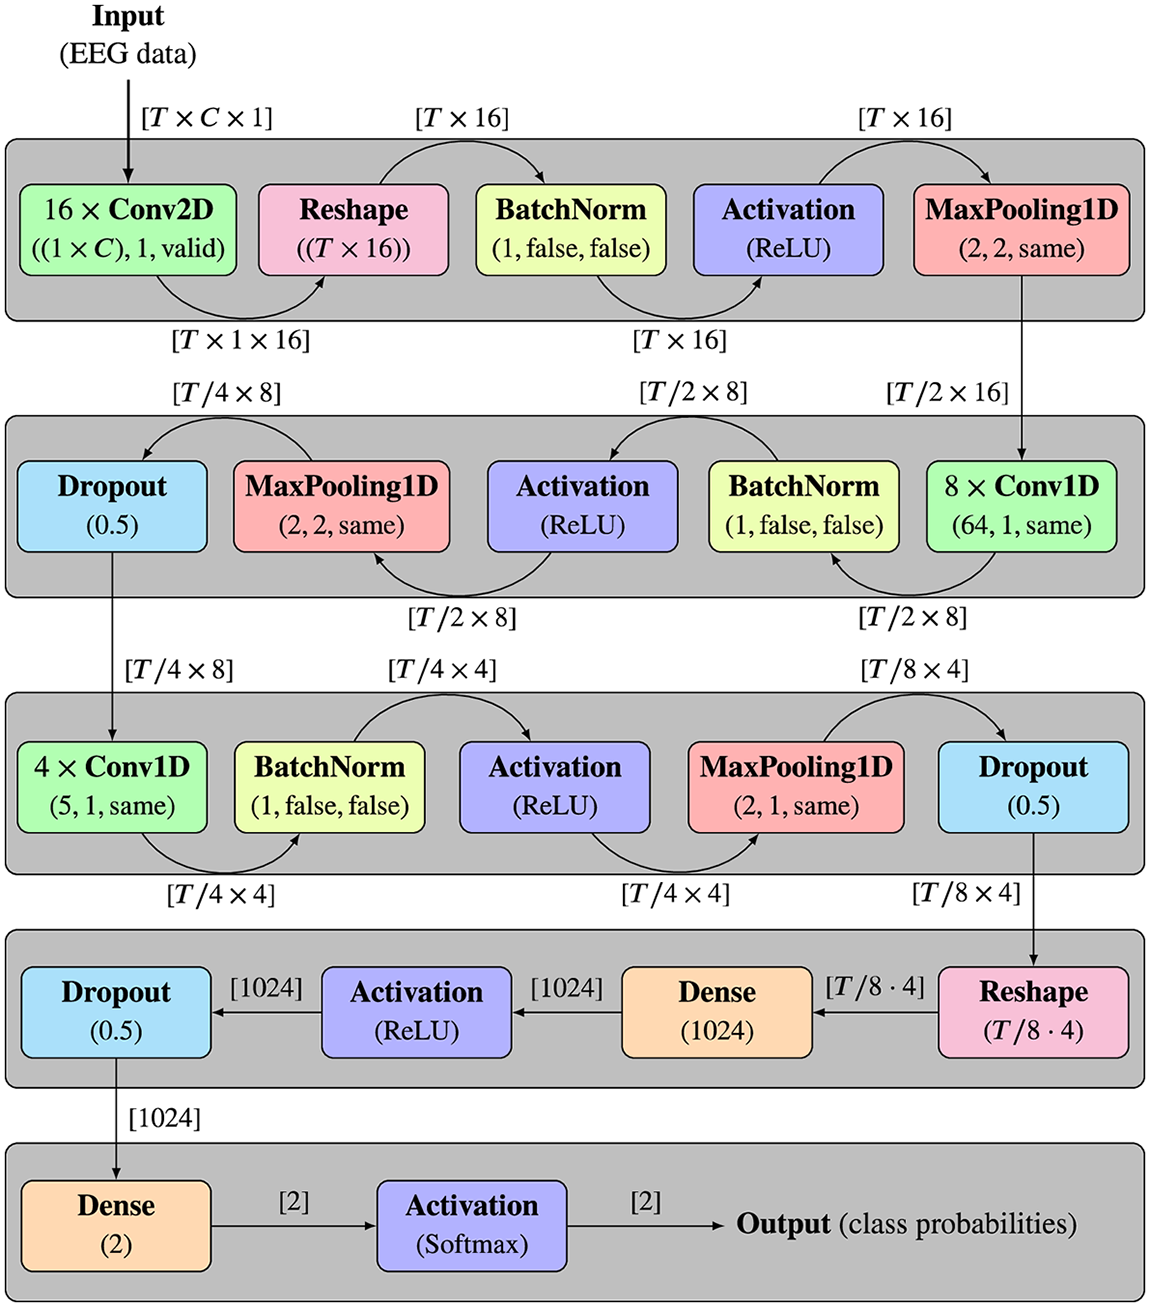

## Original Paper Performance:
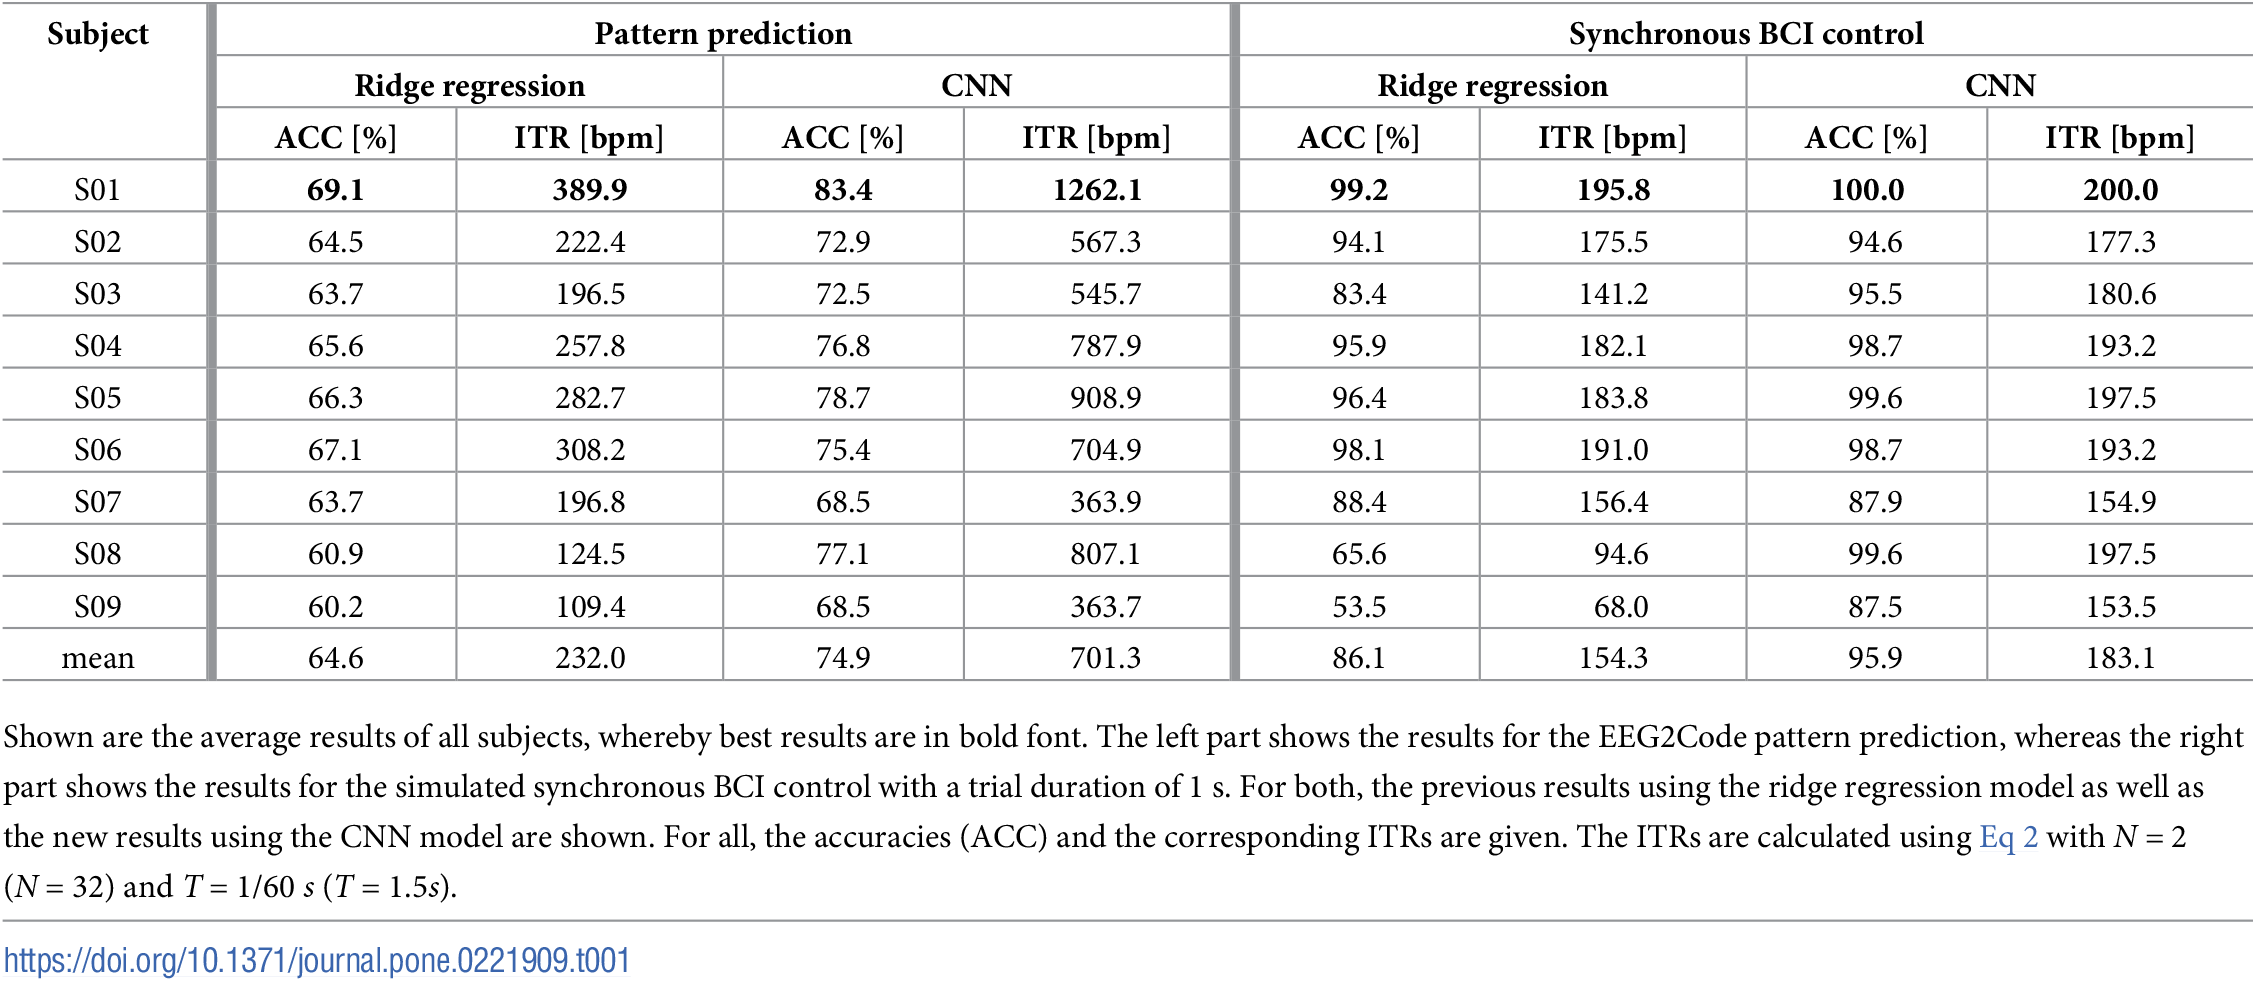

## Signal Response and Rational Behind the Data Segmentation
* Black: Stimulation pattern.
* Red: Spatially filtered EEG.
* Blue: Ridge regression predicted brain response.
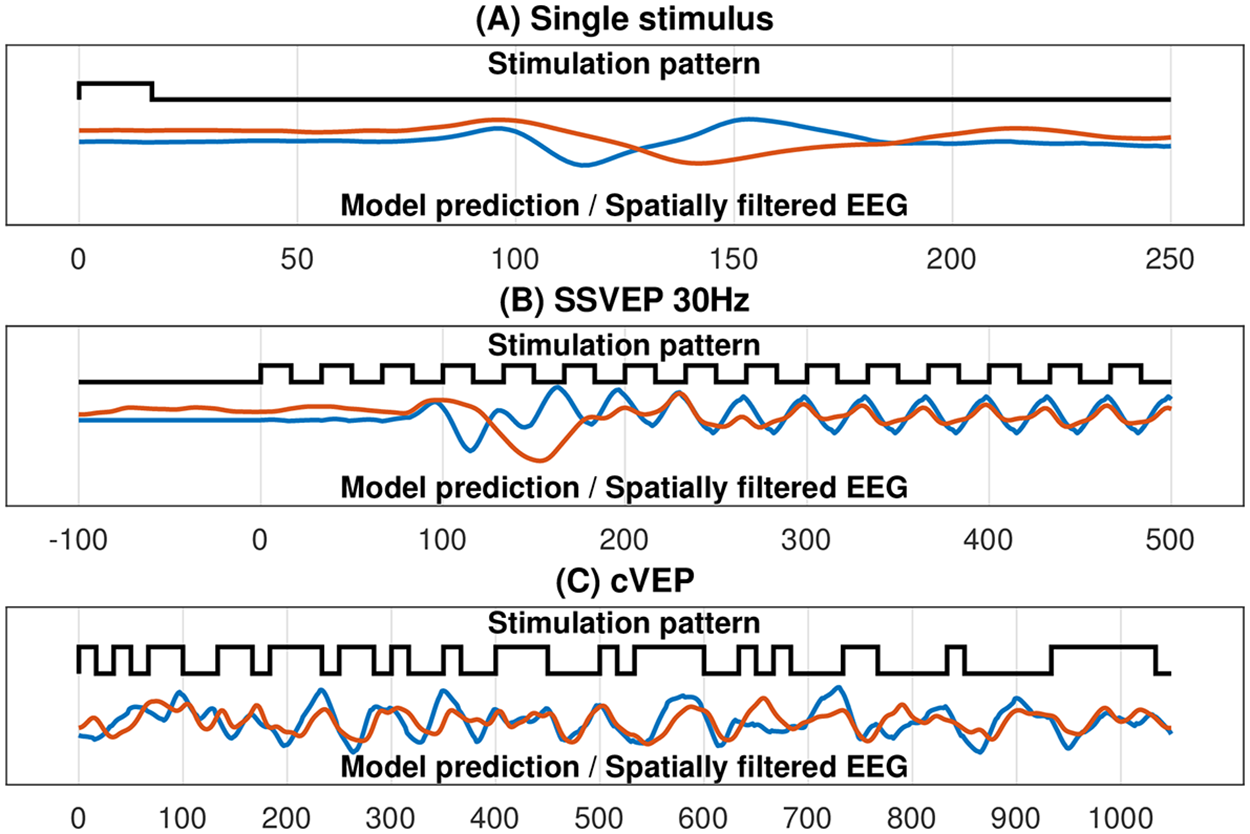

## Observations:
* EEG response has around 70ms delay after the stimulation is presented.
* The impulse response of EEG can span at least 250ms

In [ ]:
#@title Import Dependencies
import os
import sys
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import pprint
import torch
import math
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
torch.manual_seed(42)
pp = pprint.PrettyPrinter(indent=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# print(plt.style.available)

cuda


In [ ]:
#@title Download and unzip data if not exist
WORLDS_FASTEST_BCI_ZIP_NAME = '7701065.zip'
WORLDS_FASTEST_BCI_PATH = 'worlds_fastest_bci'
if not os.path.exists(WORLDS_FASTEST_BCI_PATH):
  if not os.path.isfile(WORLDS_FASTEST_BCI_ZIP_NAME):
    !wget https://figshare.com/ndownloader/articles/7701065/versions/1 -O 7701065.zip
  !unzip 7701065.zip -d worlds_fastest_bci
  # !rm 7701065.zip

# MODELLING_BRAIN_RESPONSE_ZIP_NAME = '7058900.zip'
# MODELLING_BRAIN_RESPONSE_PATH = 'modelling_brain_response'
# if not os.path.exists(MODELLING_BRAIN_RESPONSE_PATH):
#   if not os.path.isfile(MODELLING_BRAIN_RESPONSE_ZIP_NAME):
#     !wget https://figshare.com/ndownloader/articles/7058900/versions/1 -O 7058900.zip
#   !unzip 7058900.zip -d modelling_brain_response
#   # !rm 7058900.zip

# ASYNC_HIGH_SPEED_BCI_ZIP_NAME = '7611275.zip'
# ASYNC_HIGH_SPEED_BCI_PATH = 'async_high_speed_bci'
# if not os.path.exists(ASYNC_HIGH_SPEED_BCI_PATH):
#   if not os.path.isfile(ASYNC_HIGH_SPEED_BCI_ZIP_NAME):
#     !wget https://figshare.com/ndownloader/articles/7611275/versions/1 -O 7611275.zip
#   !unzip 7611275.zip -d async_high_speed_bci
#   # !rm 7611275.zip

--2023-05-01 19:39:38--  https://figshare.com/ndownloader/articles/7701065/versions/1
Resolving figshare.com (figshare.com)... 54.76.104.80, 52.48.50.28, 2a05:d018:1f4:d000:f82:26cd:8304:f369, ...
Connecting to figshare.com (figshare.com)|54.76.104.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81127696 (77M) [application/zip]
Saving to: ‘7701065.zip’

7701065.zip         100%[===================>]  77.37M  13.8MB/s    in 7.0s    

2023-05-01 19:39:46 (11.1 MB/s) - ‘7701065.zip’ saved [81127696/81127696]

Archive:  7701065.zip
 extracting: worlds_fastest_bci/VP1.mat  
 extracting: worlds_fastest_bci/VP1.hdf5  
 extracting: worlds_fastest_bci/EEG2Code.py  


In [ ]:
#@title Data Acquisition and Window Meta Data
SAMPLE_RATE_HZ = 600
DOWN_SAMPLE_FACTOR = 1
WINDOW_LEN_S = 0.25
WINDOW_LEN_FRAME = round(SAMPLE_RATE_HZ / DOWN_SAMPLE_FACTOR * WINDOW_LEN_S)
STIM_BIT_RATE_BPS = 60
STIM_BIT_LEN_S = 1 / 60
STIM_BIT_LEN_FRAME = round(SAMPLE_RATE_HZ / DOWN_SAMPLE_FACTOR * STIM_BIT_LEN_S)

print(
    f'  WINDOW_LEN_FRAME: {WINDOW_LEN_FRAME}\n' + 
    f'    STIM_BIT_LEN_S: {STIM_BIT_LEN_S:.04f}\n' + 
    f'STIM_BIT_LEN_FRAME: {STIM_BIT_LEN_FRAME}'
)

  WINDOW_LEN_FRAME: 150
    STIM_BIT_LEN_S: 0.0167
STIM_BIT_LEN_FRAME: 10


In [ ]:
#@title Deep learning EEG2Code default model as shown in the paper
class EEG2CodeDefaultModel(nn.Module):
  def __init__(self, 
    num_EEG_channel, 
    CONV1_OUT_SIZE=16, 
    CONV2_OUT_SIZE=8, CONV2_KERNEL_SIZE=64, CONV2_DROPOUT = 0.5, 
    CONV3_OUT_SIZE=4, CONV3_KERNEL_SIZE=5, CONV3_DROPOUT=0.5, 
    LINEAR1_OUT_SIZE=1024, LINEAR1_DROPOUT=0.5, 
    DOWN_SAMPLE_FACTOR=DOWN_SAMPLE_FACTOR, 
    xavier_uniform_init=True):

    super(EEG2CodeDefaultModel, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=CONV1_OUT_SIZE, kernel_size=(num_EEG_channel, 1))
    self.conv1_batch_norm = nn.BatchNorm2d(CONV1_OUT_SIZE)
    self.conv1_relu = nn.ReLU()
    self.conv1_maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
    
    self.conv2 = nn.Conv1d(in_channels=CONV1_OUT_SIZE, out_channels=CONV2_OUT_SIZE, kernel_size=CONV2_KERNEL_SIZE, padding='same')
    self.conv2_batch_norm = nn.BatchNorm1d(CONV2_OUT_SIZE)
    self.conv2_relu = nn.ReLU()
    self.conv2_maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
    self.conv2_dropout = nn.Dropout(CONV2_DROPOUT)

    self.conv3 = nn.Conv1d(in_channels=CONV2_OUT_SIZE, out_channels=CONV3_OUT_SIZE, kernel_size=CONV3_KERNEL_SIZE, padding='same')
    self.conv3_batch_norm = nn.BatchNorm1d(CONV3_OUT_SIZE)
    self.conv3_relu = nn.ReLU()
    self.conv3_maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
    self.conv3_dropout = nn.Dropout(CONV3_DROPOUT)

    self.flatten = nn.Flatten()

    if DOWN_SAMPLE_FACTOR in (1, 2, 3, 4):
      self.linear1 = nn.Linear(round(72 / DOWN_SAMPLE_FACTOR), LINEAR1_OUT_SIZE)
    elif DOWN_SAMPLE_FACTOR == 5:
      self.linear1 = nn.Linear(12, LINEAR1_OUT_SIZE)
    
    self.linear1_relu = nn.ReLU()
    self.linear1_dropout = nn.Dropout(LINEAR1_DROPOUT)

    self.linear2 = nn.Linear(LINEAR1_OUT_SIZE, 2)
    self.linear2_softmax = nn.Softmax(1)

    if xavier_uniform_init:
      self.init_hidden()

  def init_hidden(self):
    for m in self.children():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if 'bias' in m.state_dict().keys():
          torch.nn.init.zeros_(m.bias)
      
  
  def forward(self, x):
    # print(f'x before conv1: {x.size()}')
    x = self.conv1(x)
    x = self.conv1_relu(x)
    x = self.conv1_batch_norm(x)
    x = x.squeeze()
    x = self.conv1_maxpool(x)

    # print(f'x before conv2: {x.size()}')
    x = self.conv2(x)
    x = self.conv2_batch_norm(x)
    x = self.conv2_relu(x)
    x = self.conv2_maxpool(x)
    x = self.conv2_dropout(x)

    # print(f'x before conv3: {x.size()}')
    x = self.conv3(x)
    x = self.conv3_batch_norm(x)
    x = self.conv3_relu(x)
    x = self.conv3_maxpool(x)
    x = self.conv3_dropout(x)
    
    # print(f'x before linear1: {x.size()}')
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.linear1_relu(x)
    x = self.linear1_dropout(x)
    
    # print(f'x before linear2: {x.size()}')
    x = self.linear2(x)
    x = self.linear2_softmax(x)

    return x

In [ ]:
#@title My custom CNN model
class EEG2CodeCustom(nn.Module):
  def __init__(self,
    num_EEG_channel,
    CONV1_OUT_SIZE=8, CONV1_TIME_KERNEL_SIZE=int(100/DOWN_SAMPLE_FACTOR), CONV1_DROPOUT = 0.5,
    LINEAR1_OUT_SIZE=256, LINEAR1_DROPOUT=0.5, DOWN_SAMPLE_FACTOR=DOWN_SAMPLE_FACTOR,
    xavier_uniform_init=True):

    super(EEG2CodeCustom, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=CONV1_OUT_SIZE, 
                  kernel_size=(num_EEG_channel, CONV1_TIME_KERNEL_SIZE))
    self.conv1_batch_norm = nn.BatchNorm2d(CONV1_OUT_SIZE)
    self.conv1_relu = nn.ReLU()
    self.conv1_maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
    self.conv1_dropout = nn.Dropout(CONV1_DROPOUT)

    self.flatten = nn.Flatten()
    if CONV1_OUT_SIZE == 16:
      self.linear1 = nn.Linear(int(400 / DOWN_SAMPLE_FACTOR), LINEAR1_OUT_SIZE)
    elif CONV1_OUT_SIZE == 8:
      if DOWN_SAMPLE_FACTOR == 2:
        self.linear1 = nn.Linear(104, LINEAR1_OUT_SIZE)
      elif DOWN_SAMPLE_FACTOR == 10:
        self.linear1 = nn.Linear(24, LINEAR1_OUT_SIZE)
      else:
        self.linear1 = nn.Linear(int(200 / DOWN_SAMPLE_FACTOR), LINEAR1_OUT_SIZE)
      # self.linear1 = nn.Linear(176, LINEAR1_OUT_SIZE)
      # self.linear1 = nn.Linear(144, LINEAR1_OUT_SIZE)

    self.linear1_relu = nn.ReLU()
    self.linear1_dropout = nn.Dropout(LINEAR1_DROPOUT)

    self.linear2 = nn.Linear(LINEAR1_OUT_SIZE, 2)
    self.linear2_softmax = nn.Softmax(1)

    if xavier_uniform_init:
      self.init_hidden()

  def init_hidden(self):
    for m in self.children():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if 'bias' in m.state_dict().keys():
          torch.nn.init.zeros_(m.bias)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv1_relu(x)
    x = self.conv1_batch_norm(x)
    x = x.squeeze()
    x = self.conv1_maxpool(x)
    x = self.conv1_dropout(x)
    

    x = self.flatten(x)
    x = self.linear1(x)
    x = self.linear1_relu(x)
    x = self.linear1_dropout(x)
    
    x = self.linear2(x)
    x = self.linear2_softmax(x)

    return x

In [ ]:
#@title LSTM model
class EEG2CodeLSTMModel(nn.Module):
  def __init__(self, 
    num_EEG_channel, 
    LSTM_HIDDEN_SIZE=8,
    NUM_LAYERS=2,
    DROPOUT=0.5, 
    bidirectional=True,
    xavier_uniform_init=True):

    super(EEG2CodeLSTMModel, self).__init__()

    self.lstm = nn.LSTM(num_EEG_channel, LSTM_HIDDEN_SIZE, num_layers=NUM_LAYERS, batch_first=True, dropout=DROPOUT, bidirectional=bidirectional)
    self.dropout = nn.Dropout(0.5)
    self.linear = nn.Linear(LSTM_HIDDEN_SIZE * NUM_LAYERS * (int(bidirectional) + 1), 2)
    self.softmax = nn.Softmax(dim=-1)
    self.flatten = nn.Flatten()

    if xavier_uniform_init:
      self.init_hidden()

  def init_hidden(self):
    for m in self.children():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or \
         isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if 'bias' in m.state_dict().keys():
          torch.nn.init.zeros_(m.bias)

      elif isinstance(m, nn.LSTM):
        weights = m.state_dict().keys()
        # print(weights)
        if 'weight_hh_l0' in weights:
          torch.nn.init.xavier_uniform_(m.weight_hh_l0)
        if 'weight_hh_l1' in weights:
          torch.nn.init.xavier_uniform_(m.weight_hh_l1)
        if 'weight_ih_l0' in weights:
          torch.nn.init.xavier_uniform_(m.weight_ih_l0)
        if 'weight_ih_l1' in weights:
          torch.nn.init.xavier_uniform_(m.weight_ih_l1)
        if 'bias_ih_l0' in weights:
          torch.nn.init.zeros_(m.bias_ih_l0)
        if 'bias_hh_l0' in weights:
          torch.nn.init.zeros_(m.bias_hh_l0)
        if 'bias_ih_l1' in weights:
          torch.nn.init.zeros_(m.bias_ih_l1)
        if 'bias_hh_l1' in weights:
          torch.nn.init.zeros_(m.bias_hh_l1)

  def forward(self, x):
    # print(x.size())
    output, (h_n, c_n) = self.lstm(x)
    h_n = h_n.swapaxes(0, 1)
    h_n = self.dropout(h_n)
    h_n = self.flatten(h_n)
    h_n = self.linear(h_n)
    probs = self.softmax(h_n)
    return probs

Downloading...
From: https://drive.google.com/uc?id=1s43gY2jJJ1gtyxEPNB6pVZ4qLBZrwrbG
To: /content/best_EEG2CodeDefaultModel_82_68.pt
100% 356k/356k [00:00<00:00, 159MB/s]


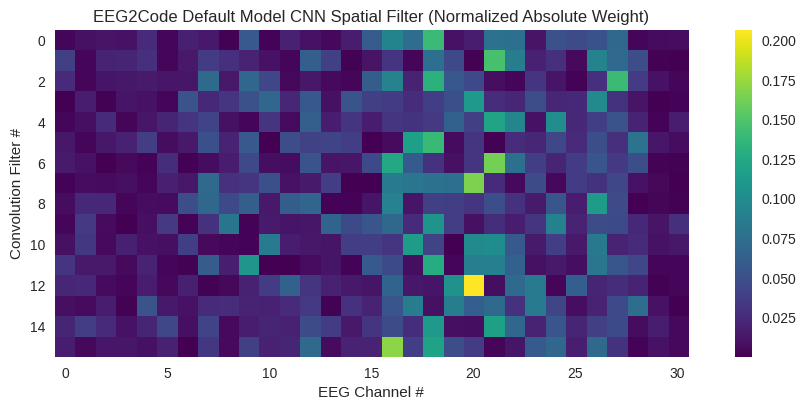

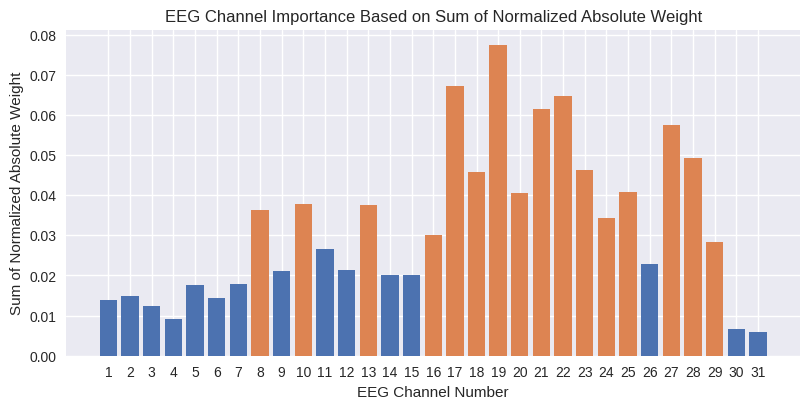

In [ ]:
#@title Extra channel selection based on EEG2Code Default Model spatial filter
SELECTED_CHANNELS = np.array(
  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32]
) - 1

# SELECT_N_BEST = SELECTED_CHANNELS.size
SELECT_N_BEST = 16
NUM_EEG_CHANNEL = SELECT_N_BEST

channel_selection_model_path = './best_EEG2CodeDefaultModel_82_68.pt'
if not os.path.isfile(channel_selection_model_path):
  !gdown 1s43gY2jJJ1gtyxEPNB6pVZ4qLBZrwrbG
channel_selection_model = torch.load(channel_selection_model_path)

spatial_filter = list(channel_selection_model.children())[0].weight.squeeze().cpu().detach().numpy()
spatial_filter_abs_val = np.abs(spatial_filter)
spatial_filter_abs_val_normalized = (spatial_filter_abs_val.T / spatial_filter_abs_val.sum(axis=-1)).T
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
im = ax.imshow(spatial_filter_abs_val_normalized, cmap='viridis')
ax.set_xlabel('EEG Channel #')
ax.set_ylabel('Convolution Filter #')
ax.grid(False)
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.title('EEG2Code Default Model CNN Spatial Filter (Normalized Absolute Weight)')
plt.show()

feature_importance = spatial_filter_abs_val_normalized.T.mean(axis=-1)
best_channel_ind = np.argsort(feature_importance)[-SELECT_N_BEST:][::-1]
SELECTED_CHANNELS = SELECTED_CHANNELS[best_channel_ind]

fig, ax = plt.subplots(1, 1, figsize=(8.2, 4))
channel_num = [f'{chnl_num}' for chnl_num in (np.arange(feature_importance.size) + 1)]
color = np.array([(0.2980, 0.4471, 0.6902)] * feature_importance.size)
color[best_channel_ind] = (0.8667, 0.5176, 0.3216)
ax.bar(channel_num, feature_importance, color=color)
# ax.bar(channel_num, feature_importance)
# ax.grid(False)

ax.set_ylabel('Sum of Normalized Absolute Weight')
ax.set_xlabel('EEG Channel Number')
plt.tight_layout()
plt.title('EEG Channel Importance Based on Sum of Normalized Absolute Weight')
plt.show()



In [ ]:
#@title Load worlds_fastest_bci data
filename = f'{WORLDS_FASTEST_BCI_PATH}/VP1.mat'
mat_contents = sio.loadmat(filename)
train_x = np.array(mat_contents['train_data_x'], dtype=np.float32)
train_y = np.array(mat_contents['train_data_y'])
test_x  = np.array(mat_contents['test_data_x'], dtype=np.float32)
test_y  = np.array(mat_contents['test_data_y'])

train_x_num_run, train_x_num_chn, train_x_num_frame = train_x.shape
train_x = train_x[:, SELECTED_CHANNELS, :].reshape(
    train_x_num_run, len(SELECTED_CHANNELS), 
    int(train_x_num_frame / DOWN_SAMPLE_FACTOR), DOWN_SAMPLE_FACTOR).mean(axis=-1)
train_y = train_y.reshape(
    train_x_num_run, int(train_x_num_frame / DOWN_SAMPLE_FACTOR), 
    DOWN_SAMPLE_FACTOR).mean(axis=-1).round()

test_x_num_run, test_x_num_chn, test_x_num_frame = test_x.shape
test_x = test_x[:, SELECTED_CHANNELS, :].reshape(
    test_x_num_run, len(SELECTED_CHANNELS), 
    int(test_x_num_frame / DOWN_SAMPLE_FACTOR), DOWN_SAMPLE_FACTOR).mean(axis=-1)
test_y = test_y.reshape(
    test_x_num_run, int(test_x_num_frame / DOWN_SAMPLE_FACTOR), 
    DOWN_SAMPLE_FACTOR).mean(axis=-1).round()

train_x_num_run, train_x_num_chn, train_x_num_frame = train_x.shape
validate_start_run_ind = round(train_x_num_run * 0.5)
validate_x = train_x[validate_start_run_ind:, :, :]

train_x = train_x[:validate_start_run_ind, :, :]
validate_x_num_run, validate_x_num_chn, validate_x_num_frame = validate_x.shape

validate_y = train_y[validate_start_run_ind:, :]
train_y = train_y[:validate_start_run_ind, :]
train_x_num_run, train_x_num_chn, train_x_num_frame = train_x.shape
train_y_num_run, train_y_num_frame = train_y.shape
train_slice_ind_end = train_x_num_frame - WINDOW_LEN_FRAME

test_x_num_run, test_x_num_chn, test_x_num_frame = test_x.shape
test_y_num_run, test_y_num_frame = test_y.shape
test_slice_ind_end = test_x_num_frame - WINDOW_LEN_FRAME

In [ ]:
#@title Model training parameters
NUM_EPOCH = 200
BATCH_SIZE = 2048
EARLY_TERMINATION_THRESHOLD = 0.1
# BATCH_SIZE = 16
LR = 0.002
# LR = 0.0006
# WEIGHT_DECAY = 0.005
# MOMENTUM = 0.9
VALIDATE_BATCH_SIZE = 16384

# model = EEG2CodeDefaultModel(num_EEG_channel=NUM_EEG_CHANNEL).to(device)
model = EEG2CodeCustom(num_EEG_channel=NUM_EEG_CHANNEL).to(device)
# model = EEG2CodeLSTMModel(num_EEG_channel=NUM_EEG_CHANNEL).to(device)
MODEL_SAVE_PATH = f'best_{model.__class__.__name__}.pt'
if os.path.exists(MODEL_SAVE_PATH):
  os.remove(MODEL_SAVE_PATH)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=LR, 
                            # weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
#@title Alternative data slicing accounting for neurological signal propogation delay
ACCOUNT_FOR_DELAY = False
if ACCOUNT_FOR_DELAY:
  NEURO_SIGNAL_DELAY_S = 0.1
else:
  NEURO_SIGNAL_DELAY_S = 0
NEURO_SIGNAL_DELAY_FRAME = int(NEURO_SIGNAL_DELAY_S * WINDOW_LEN_FRAME)

# Best results:
## Using the default model in paper:
### Parameters:
``` python
model = EEG2CodeDefaultModel(xavier_uniform_init=True)
NUM_EPOCH = 25
BATCH_SIZE = 2048
LR = 0.003
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
```
### Performance:
* If downsample by 1:
  * Test Accuracy: 0.8236 
  * Test_loss: 0.4747 
  * Not smoothed accuracy: 0.7889

* If downsample by 2:
  * Test Accuracy: 0.8210 
  * Test_loss: 0.4655 
  * Not smoothed accuracy: 0.7837

* If downsample by 5:
  * Test Accuracy: 0.8030 
  * Test_loss: 0.4917 
  * Not smoothed accuracy: 0.7723

### Using **Best 16** Channels Performance:
* If downsample by 1:
  * Test Accuracy: 0.8186 
  * Test_loss: 0.4750 
  * Not smoothed accuracy: 0.7838

* If downsample by 2:
  * Test Accuracy: 0.8060 
  * Test_loss: 0.4845 
  * Not smoothed accuracy: 0.7731

* If downsample by 5:
  * Test Accuracy: 0.8031 
  * Test_loss: 0.4891 
  * Not smoothed accuracy: 0.7730


## Using custom CNN:
### parameters:
``` python
NUM_EPOCH = 200 # Best epoch = 107, early terminated at 122
BATCH_SIZE = 2048
LR = 0.002
model = EEG2CodeCustom(time_window_num_frame=WINDOW_LEN_FRAME, num_EEG_channel=NUM_EEG_CHANNEL,
    CONV1_OUT_SIZE=8, CONV1_TIME_KERNEL_SIZE=100, CONV1_DROPOUT = 0.5,
    LINEAR1_OUT_SIZE=256, LINEAR1_DROPOUT=0.5,
    xavier_uniform_init=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
```
### Performance:
* If downsample by 1:
  * Test Accuracy: 0.8499 
  * Test_loss: 0.4108 
  * Not smoothed accuracy: 0.8178

* If downsample by 2:
  * Test Accuracy: 0.8487 
  * Test_loss: 0.4082 
  * Not smoothed accuracy: 0.8172

* If downsample by 5:
  * Test Accuracy: 0.8321 
  * Test_loss: 0.3961 
  * Not smoothed accuracy: 0.8215

### Using **Best 16** channel Performace:
* If downsample by 1:
  * Test Accuracy: 0.8541 
  * Test_loss: 0.4080 
  * Not smoothed accuracy: 0.8187

* If downsample by 2:
  * Test Accuracy: 0.8546 
  * Test_loss: 0.4042 
  * Not smoothed accuracy: 0.8209

* If downsample by 5:
  * Test Accuracy: 0.8371 
  * Test_loss: 0.3878 
  * Not smoothed accuracy: 0.8260

In [ ]:
#@title Train the model
train_x_num_samples = train_x_num_run * train_slice_ind_end
num_train_batch = math.ceil(train_x_num_samples / BATCH_SIZE)
train_batch_start_i_arr = np.arange(num_train_batch) * BATCH_SIZE

validate_x_num_samples = validate_x_num_run * train_slice_ind_end
num_validate_batch = math.ceil(validate_x_num_samples / VALIDATE_BATCH_SIZE)
test_batch_start_i_arr = np.arange(num_validate_batch) * VALIDATE_BATCH_SIZE

best_validate_acc = 0
min_validate_loss = sys.float_info.max

train_acc_arr = np.zeros(NUM_EPOCH)
train_loss_arr = np.zeros(NUM_EPOCH)
validate_acc_arr = np.zeros(NUM_EPOCH)
validate_loss_arr = np.zeros(NUM_EPOCH)
for epoch_i in range(NUM_EPOCH):
  num_correct = 0
  weighted_train_loss_arr = np.zeros(train_batch_start_i_arr.size)
  for batch_i, sample_ind_start in enumerate(train_batch_start_i_arr):
    sample_ind_end = min(train_x_num_samples, sample_ind_start + BATCH_SIZE)
    sample_ind = np.arange(sample_ind_start, sample_ind_end)
    sample_run_ind = np.floor(sample_ind / train_slice_ind_end).astype(int)
    sample_start_ind =  (sample_ind - sample_run_ind * train_slice_ind_end).astype(int)
    train_x_batch_i = np.array([
      train_x[run_i, :, (start_i + NEURO_SIGNAL_DELAY_FRAME):(start_i + WINDOW_LEN_FRAME)]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=np.float32)

    train_y_batch_i = np.array([
      train_y[run_i, start_i]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=int)
    if model.__class__.__name__ in ['EEG2CodeDefaultModel', 'EEG2CodeCustom']:
      train_x_batch_i = torch.from_numpy(np.expand_dims(train_x_batch_i, axis=1)).to(device)
    elif model.__class__.__name__ in ['EEG2CodeLSTMModel']:
      train_x_batch_i = torch.from_numpy(train_x_batch_i.swapaxes(1,2)).to(device)
    train_y_batch_i = torch.from_numpy(train_y_batch_i).to(device)
    optimizer.zero_grad()
    outputs = model(train_x_batch_i)
    # print(train_x_batch_i.size())
    # break
    train_y_batch_i_one_hot = torch.nn.functional.one_hot(train_y_batch_i, num_classes=2)
    loss = criterion(input=outputs, target=train_y_batch_i_one_hot.type(torch.float32))
    weighted_train_loss_arr[batch_i] = loss.cpu().detach().numpy() * sample_ind.size
    loss.backward()
    optimizer.step()

    train_x_predict = outputs.argmax(axis=-1)
    train_batch_num_correct = torch.sum(train_x_predict == train_y_batch_i)
    num_correct += train_batch_num_correct.cpu().detach().numpy()
  # break
  model.eval()
  with torch.no_grad():
    num_validate_correct = 0
    weighted_validate_loss_arr = np.zeros(test_batch_start_i_arr.size)
    for validate_batch_i, sample_ind_start in enumerate(test_batch_start_i_arr):
      sample_ind_end = min(validate_x_num_samples, sample_ind_start + VALIDATE_BATCH_SIZE)
      sample_ind = np.arange(sample_ind_start, sample_ind_end)
      sample_run_ind = np.floor(sample_ind / train_slice_ind_end).astype(int)
      sample_start_ind =  (sample_ind % train_slice_ind_end).astype(int)
      validate_x_batch_i = np.array([
        validate_x[run_i, :, (start_i + NEURO_SIGNAL_DELAY_FRAME):(start_i + WINDOW_LEN_FRAME)]
        for run_i, start_i in zip(sample_run_ind, sample_start_ind)
      ], dtype=np.float32)

      validate_y_batch_i = np.array([
        validate_y[run_i, start_i]
        for run_i, start_i in zip(sample_run_ind, sample_start_ind)
      ], dtype=int)

      if model.__class__.__name__ in ['EEG2CodeDefaultModel', 'EEG2CodeCustom']:
        validate_x_batch_i = torch.from_numpy(np.expand_dims(validate_x_batch_i, axis=1)).to(device)
      elif model.__class__.__name__ in ['EEG2CodeLSTMModel']:
        validate_x_batch_i = torch.from_numpy(validate_x_batch_i.swapaxes(1,2)).to(device)

      validate_y_batch_i = torch.from_numpy(validate_y_batch_i).to(device)
      # print(validate_x_batch_i.size())
      validate_out = model(validate_x_batch_i)
      # print(validate_out.size())
      # break
      weighted_validate_loss_arr[validate_batch_i] = criterion(
        input=validate_out, 
        target=torch.nn.functional.one_hot(validate_y_batch_i).type(torch.float32)
      ).cpu().detach().numpy() * sample_ind.size

      validate_x_predict = validate_out.argmax(axis=-1)
      num_validate_correct += torch.sum(validate_x_predict == validate_y_batch_i).cpu().detach().numpy()
    # break
  model.train()
  train_loss = np.sum(weighted_train_loss_arr) / train_x_num_samples
  train_acc = (num_correct / train_x_num_samples)

  validate_loss = np.sum(weighted_validate_loss_arr) / validate_x_num_samples
  validate_acc = (num_validate_correct / validate_x_num_samples)

  is_best = validate_acc > best_validate_acc
  
  print(
    f'Epoch: {epoch_i+1:02}/{NUM_EPOCH}\n' + 
    f'train_acc: {train_acc:.4f} ' +
    f'train_loss: {train_loss:.4f} ' + 
    f'validate_acc: {validate_acc:.4f} ' + 
    f'validate_loss: {validate_loss:.4f} ' +
    f'is_best: {is_best}'
  )
  train_acc_arr[epoch_i] = train_acc
  train_loss_arr[epoch_i] = train_loss
  validate_acc_arr[epoch_i] = validate_acc
  validate_loss_arr[epoch_i] = validate_loss

  if is_best:
    torch.save(model, MODEL_SAVE_PATH)
    best_validate_acc = validate_acc
  
  if validate_loss < min_validate_loss:
    min_validate_loss = validate_loss
  elif validate_loss > (min_validate_loss + min_validate_loss * EARLY_TERMINATION_THRESHOLD):
    print('probably overfitted! terminate training')
    break

Epoch: 01/200
train_acc: 0.5804 train_loss: 0.8780 validate_acc: 0.6704 validate_loss: 0.6045 is_best: True
Epoch: 02/200
train_acc: 0.6490 train_loss: 0.6478 validate_acc: 0.7112 validate_loss: 0.5605 is_best: True
Epoch: 03/200
train_acc: 0.6877 train_loss: 0.5868 validate_acc: 0.7255 validate_loss: 0.5438 is_best: True
Epoch: 04/200
train_acc: 0.7082 train_loss: 0.5620 validate_acc: 0.7361 validate_loss: 0.5305 is_best: True
Epoch: 05/200
train_acc: 0.7248 train_loss: 0.5425 validate_acc: 0.7427 validate_loss: 0.5222 is_best: True
Epoch: 06/200
train_acc: 0.7344 train_loss: 0.5285 validate_acc: 0.7493 validate_loss: 0.5125 is_best: True
Epoch: 07/200
train_acc: 0.7405 train_loss: 0.5215 validate_acc: 0.7538 validate_loss: 0.5057 is_best: True
Epoch: 08/200
train_acc: 0.7486 train_loss: 0.5108 validate_acc: 0.7598 validate_loss: 0.4981 is_best: True
Epoch: 09/200
train_acc: 0.7551 train_loss: 0.5040 validate_acc: 0.7630 validate_loss: 0.4923 is_best: True
Epoch: 10/200
train_acc: 0.7

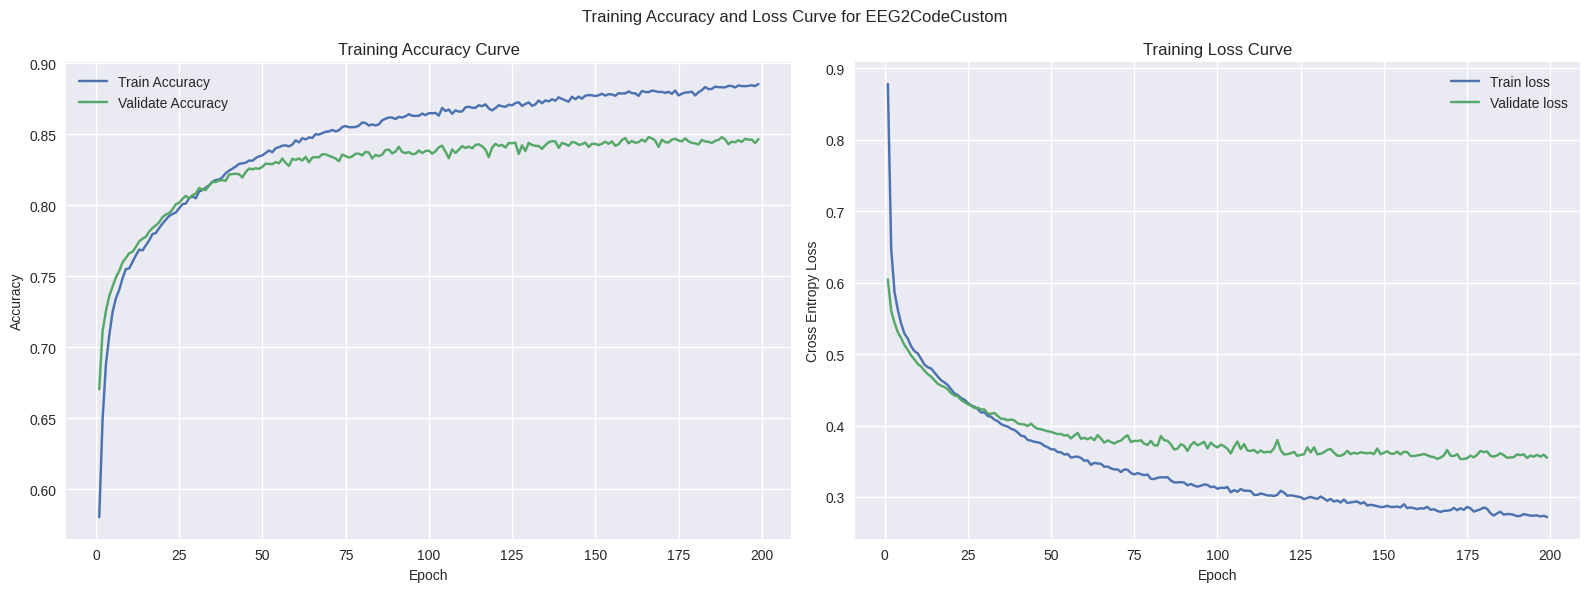

In [ ]:
fig, (acc_ax, loss_ax) = plt.subplots(1, 2, figsize=(16, 6))

epoch = np.arange(epoch_i) + 1
acc_ax.plot(epoch, train_acc_arr[:epoch_i], label='Train Accuracy')
acc_ax.plot(epoch, validate_acc_arr[:epoch_i], label='Validate Accuracy')
acc_ax.set_xlabel('Epoch')
acc_ax.set_ylabel('Accuracy')
acc_ax.legend()
acc_ax.set_title('Training Accuracy Curve')

loss_ax.plot(epoch, train_loss_arr[:epoch_i], label='Train loss')
loss_ax.plot(epoch, validate_loss_arr[:epoch_i], label='Validate loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Cross Entropy Loss')
loss_ax.legend()
loss_ax.set_title('Training Loss Curve')

plt.suptitle(f'Training Accuracy and Loss Curve for {model.__class__.__name__}')
plt.tight_layout()
plt.show()

In [ ]:
#@title Test the model
TEST_BATCH_SIZE = test_slice_ind_end
test_x_num_samples = test_x_num_run * test_slice_ind_end
num_test_batch = math.ceil(test_x_num_samples / TEST_BATCH_SIZE)
model.eval()
with torch.no_grad():
  num_test_correct = 0
  num_test_correct_raw = 0
  test_loss_arr = []
  for test_batch_i in range(num_test_batch):
    sample_ind_start = test_batch_i * TEST_BATCH_SIZE
    if test_batch_i == (num_test_batch - 1):
      sample_ind_end = test_x_num_samples
    else:
      sample_ind_end = (test_batch_i + 1) * TEST_BATCH_SIZE
    sample_ind = np.arange(sample_ind_start, sample_ind_end)
    sample_run_ind = np.floor(sample_ind / test_slice_ind_end).astype(int)
    sample_start_ind =  (sample_ind % test_slice_ind_end).astype(int)
    test_x_batch_i = np.array([
      test_x[run_i, :, (start_i + NEURO_SIGNAL_DELAY_FRAME):(start_i + WINDOW_LEN_FRAME)]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=np.float32)

    test_y_batch_i = np.array([
      test_y[run_i, start_i]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=int)

    if model.__class__.__name__ in ['EEG2CodeDefaultModel', 'EEG2CodeCustom']:
      test_x_batch_i = torch.from_numpy(np.expand_dims(test_x_batch_i, axis=1)).to(device)
    elif model.__class__.__name__ in ['EEG2CodeLSTMModel']:
      test_x_batch_i = torch.from_numpy(test_x_batch_i.swapaxes(1,2)).to(device)

    # test_x_batch_i = torch.from_numpy(np.expand_dims(test_x_batch_i, axis=1)).to(device)
    test_y_batch_i = torch.from_numpy(test_y_batch_i).to(device)
  
    test_out = model(test_x_batch_i)
    test_y_batch_i_one_hot = torch.nn.functional.one_hot(test_y_batch_i).type(torch.float32)
    test_loss_arr.append(criterion(test_out, test_y_batch_i_one_hot).cpu().detach().numpy())
  
    test_x_predict = test_out.argmax(axis=-1)
    num_test_correct_raw += torch.sum(test_x_predict == test_y_batch_i).cpu().detach().numpy()

    reduced_test_x_predict = test_out[:, 1].reshape(int(sample_ind.size / STIM_BIT_LEN_FRAME), STIM_BIT_LEN_FRAME).mean(axis=1) > 0.5
    recuded_test_y_batch_i = test_y_batch_i.type(torch.float32).reshape(int(sample_ind.size / STIM_BIT_LEN_FRAME), STIM_BIT_LEN_FRAME).mean(axis=1) > 0.5

    num_test_correct += np.sum(reduced_test_x_predict.cpu().detach().numpy() == recuded_test_y_batch_i.cpu().detach().numpy())

  test_acc = num_test_correct / test_x_num_samples * STIM_BIT_LEN_FRAME
  not_smoothed_test_acc = num_test_correct_raw / test_x_num_samples
print(
  f'Test Accuracy: {test_acc:.4f} ' +
  f'test_loss: {np.mean(test_loss_arr):.4f} ' + 
  f'not smoothed accuracy: {not_smoothed_test_acc:.4f}'
)

Test Accuracy: 0.8541 test_loss: 0.4080 not smoothed accuracy: 0.8187


In [ ]:
#@title Model testing parameters
TEST_BATCH_SIZE = test_slice_ind_end
model = torch.load(MODEL_SAVE_PATH)

In [ ]:
#@title Test the model
test_x_num_samples = test_x_num_run * test_slice_ind_end
num_test_batch = math.ceil(test_x_num_samples / TEST_BATCH_SIZE)
model.eval()
with torch.no_grad():
  num_test_correct = 0
  num_test_correct_raw = 0
  test_loss_arr = []
  for test_batch_i in range(num_test_batch):
    sample_ind_start = test_batch_i * TEST_BATCH_SIZE
    if test_batch_i == (num_test_batch - 1):
      sample_ind_end = test_x_num_samples
    else:
      sample_ind_end = (test_batch_i + 1) * TEST_BATCH_SIZE
    sample_ind = np.arange(sample_ind_start, sample_ind_end)
    sample_run_ind = np.floor(sample_ind / test_slice_ind_end).astype(int)
    sample_start_ind =  (sample_ind % test_slice_ind_end).astype(int)
    test_x_batch_i = np.array([
      test_x[run_i, :, (start_i + NEURO_SIGNAL_DELAY_FRAME):(start_i + WINDOW_LEN_FRAME)]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=np.float32)

    test_y_batch_i = np.array([
      test_y[run_i, start_i]
      for run_i, start_i in zip(sample_run_ind, sample_start_ind)
    ], dtype=int)

    if model.__class__.__name__ in ['EEG2CodeDefaultModel', 'EEG2CodeCustom']:
      test_x_batch_i = torch.from_numpy(np.expand_dims(test_x_batch_i, axis=1)).to(device)
    elif model.__class__.__name__ in ['EEG2CodeLSTMModel']:
      test_x_batch_i = torch.from_numpy(test_x_batch_i.swapaxes(1,2)).to(device)

    # test_x_batch_i = torch.from_numpy(np.expand_dims(test_x_batch_i, axis=1)).to(device)
    test_y_batch_i = torch.from_numpy(test_y_batch_i).to(device)
  
    test_out = model(test_x_batch_i)
    test_y_batch_i_one_hot = torch.nn.functional.one_hot(test_y_batch_i).type(torch.float32)
    test_loss_arr.append(criterion(test_out, test_y_batch_i_one_hot).cpu().detach().numpy())
  
    test_x_predict = test_out.argmax(axis=-1)
    num_test_correct_raw += torch.sum(test_x_predict == test_y_batch_i).cpu().detach().numpy()

    reduced_test_x_predict = test_out[:, 1].reshape(int(sample_ind.size / STIM_BIT_LEN_FRAME), STIM_BIT_LEN_FRAME).mean(axis=1) > 0.5
    recuded_test_y_batch_i = test_y_batch_i.type(torch.float32).reshape(int(sample_ind.size / STIM_BIT_LEN_FRAME), STIM_BIT_LEN_FRAME).mean(axis=1) > 0.5

    num_test_correct += np.sum(reduced_test_x_predict.cpu().detach().numpy() == recuded_test_y_batch_i.cpu().detach().numpy())

  test_acc = num_test_correct / test_x_num_samples * STIM_BIT_LEN_FRAME
  not_smoothed_test_acc = num_test_correct_raw / test_x_num_samples
print(
  f'Test Accuracy: {test_acc:.4f} ' +
  f'test_loss: {np.mean(test_loss_arr):.4f} ' + 
  f'not smoothed accuracy: {not_smoothed_test_acc:.4f}'
)

Test Accuracy: 0.8541 test_loss: 0.4080 not smoothed accuracy: 0.8187


# Potential Future Direction:
Recap: Current implementation uses a frame-by-frame sliding CNN as a frame-by-frame 0/1 state classifier.
## Classification Approach: 
### Alternative Bit Encoding scheme using Machester encoding.
* No long gap.
* Classifying transitions again, which should give better saliency than a steady state.
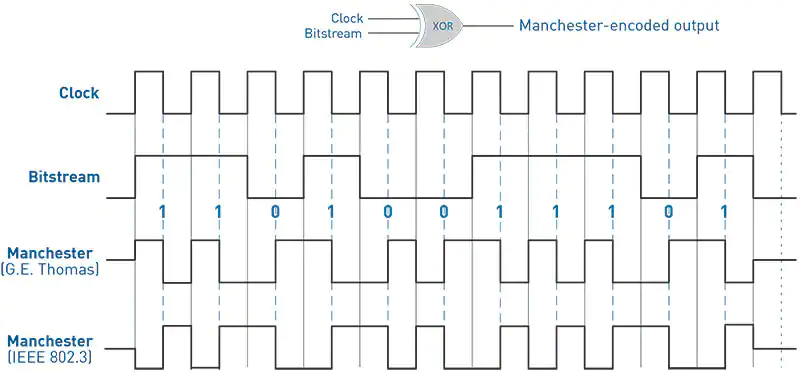


## Regression Approach:
### DL as a non-linear fancy regressor to 'correct' spatially filtered EEG results to match stimulus signal

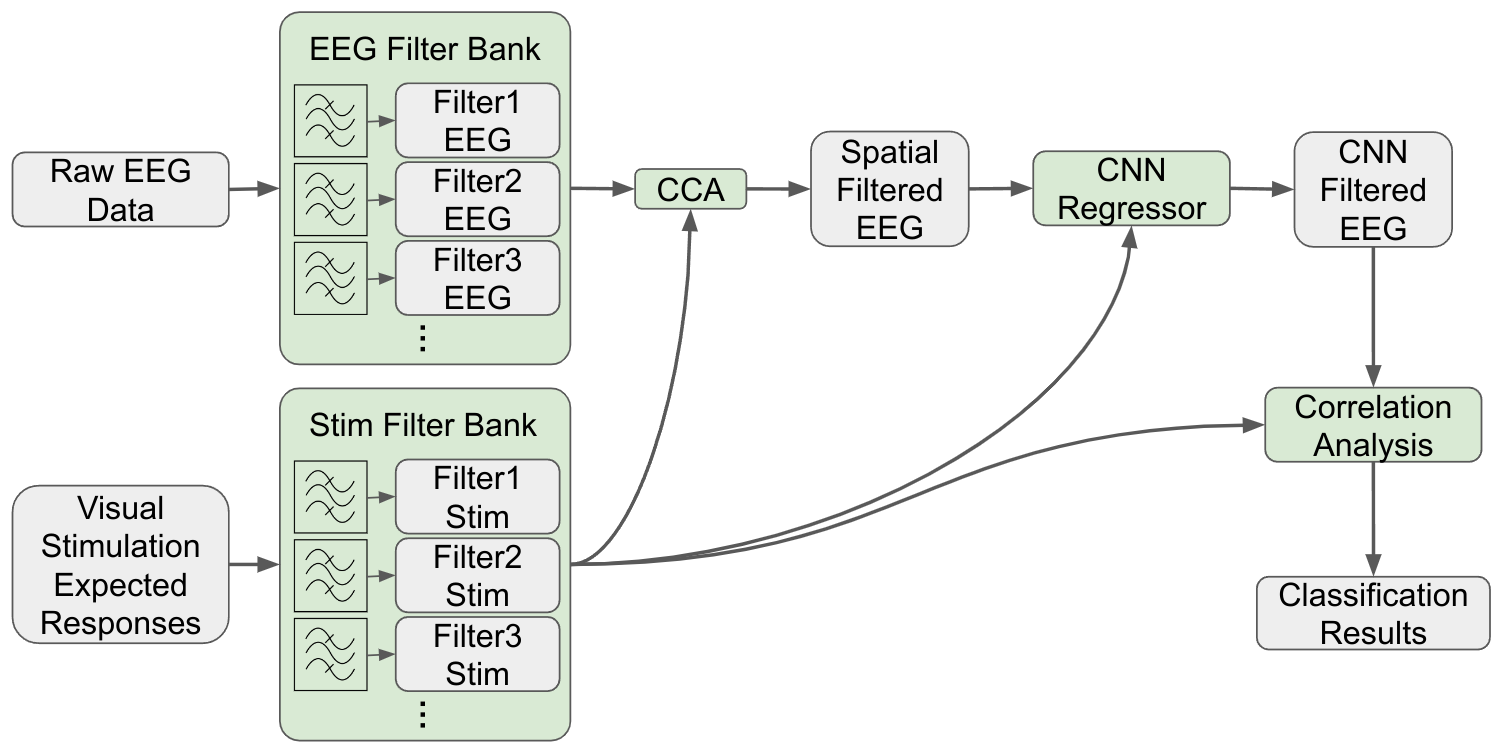